In [41]:
import os

import json
import requests
import tensorflow
import warnings
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, Conv3D, Conv1D, MaxPooling1D, Flatten
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns  
from sklearn.metrics import mean_absolute_error
from keras.initializers import Constant
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from keras.models import load_model
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import datetime

warnings.filterwarnings('ignore')


In [88]:
crypto=input("Enter Choice of Crypto using their abbreviation (BTC,ETH, etc)\n")
fiat=input("Enter Choice of Currency using their abbreviation (INR,USD, etc)\n")
limit=input("Enter the time frame (0-2000)\n")
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym='+crypto+'&tsym='+fiat+'&limit='+str(limit))
hist = pd.DataFrame(json.loads(res.content)['Data'])
# hist['time'] = hist['time'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d'))

hist['time'] = pd.to_datetime(hist['time'], unit='s')
# hist.set_index('time',inplace=True)
# hist.index = pd.to_datetime(hist.index, unit='s')
hist = hist.set_index('time')
target_col = 'close'

hist=hist[hist['close']!=0]

hist.drop(["conversionType", "conversionSymbol"], axis = 'columns', inplace = True)

In [89]:
hist['low']

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2018-11-01,6402.59,6322.60,6342.81,31397.71,1.998612e+08,6381.30
2018-11-02,6420.93,6371.57,6381.30,27987.60,1.793856e+08,6394.66
2018-11-03,6398.09,6336.96,6394.65,28808.38,1.835653e+08,6376.32
2018-11-04,6498.16,6351.92,6376.55,27317.02,1.758052e+08,6467.05
2018-11-05,6475.80,6406.69,6467.05,24142.00,1.557589e+08,6433.74
...,...,...,...,...,...,...
2024-04-19,65491.94,59607.49,63511.20,46058.39,2.923365e+09,63848.26
2024-04-20,65453.07,63140.68,63848.26,13464.03,8.661055e+08,64979.21
2024-04-21,65724.22,64271.77,64979.21,13150.64,8.543242e+08,64955.82


In [4]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data
 

In [5]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=5):
    fig, ax = plt.subplots(1, figsize=(14, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_xlabel(crypto, fontsize=14)
    ax.set_ylabel(fiat, fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
    plt.show()

In [6]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

# def scaler_func(df):
#     return scaler.fit_transform()

def normalise_min_max(df):
    return (df - df.min()) / (df.max() - df.min())

In [7]:
def extract_window_data(df, window_len=10, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
    # for idx in range(len(df)):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [73]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

train, test, X_train, X_test, y_train, y_test = prepare_data(hist, target_col)

<font size='6'>LSTM MODEL.

In [74]:
def build_lstm_model(neurons=512, activ_func='linear',
                     dropout=0.3, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=1))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

# np.random.seed(42)
# window_len = 10
# test_size = 0.2
# zero_base = True
# lstm_neurons = 512
# epochs = 40
# batch_size = 32
# loss = 'mse'
# dropout = 0.2
# optimizer = 'adam'

In [27]:
# np.random.seed(42)

# grid_model = KerasRegressor(build_fn=build_lstm_model,verbose=0)
# # grid_param = {
# #     'neurons':[64,128,256,512],
# #     'activ_func' :['linear','relu','sigmoid'],
# #     'dropout':[0.2,0.25,0.3,0.35],
# #     'optimizer':['adam','rmsprop'],
# #     'batch_size' : [16, 32, 64],
# #     'epochs' : [15, 25, 35]

# # }
# grid_param = {
#     'neurons':[64,128,256],
#     'activ_func' :['linear','relu'],
#     'dropout':[0.2,0.3],
#     'optimizer':['adam'],
#     'batch_size' : [16, 32],
#     'epochs' : [20]

# }

# grid = GridSearchCV(estimator=grid_model,param_grid=grid_param,cv=3,n_jobs=-1)

# grid_result = grid.fit(X_train, y_train, validation_data=(X_test, y_test))


In [28]:
# print(f"Best score: {grid_result.best_score_} using {grid_result.best_params_}")

Best score: -0.001847066916525364 using {'activ_func': 'linear', 'batch_size': 16, 'dropout': 0.3, 'epochs': 20, 'neurons': 256, 'optimizer': 'adam'}


In [75]:
model = build_lstm_model(neurons=512,activ_func='linear', dropout=0.3, loss='mse',optimizer='adam')
# history = History()
history = model.fit(X_train, 
            y_train, 
            validation_data=(X_test, y_test), 
            epochs=30, 
            batch_size=16, 
            verbose=1, 
            shuffle=True,
            )


Epoch 1/30
100/100 [==============================] - 5s 40ms/step - loss: 0.0084 - val_loss: 0.0022
Epoch 2/30
100/100 [==============================] - 4s 37ms/step - loss: 0.0034 - val_loss: 0.0012
Epoch 3/30
100/100 [==============================] - 4s 37ms/step - loss: 0.0027 - val_loss: 7.8809e-04
Epoch 4/30
100/100 [==============================] - 4s 40ms/step - loss: 0.0025 - val_loss: 9.8468e-04
Epoch 5/30
100/100 [==============================] - 4s 37ms/step - loss: 0.0022 - val_loss: 9.0113e-04
Epoch 6/30
100/100 [==============================] - 4s 38ms/step - loss: 0.0021 - val_loss: 6.8797e-04
Epoch 7/30
100/100 [==============================] - 4s 36ms/step - loss: 0.0022 - val_loss: 7.1340e-04
Epoch 8/30
100/100 [==============================] - 4s 37ms/step - loss: 0.0020 - val_loss: 7.1686e-04
Epoch 9/30
100/100 [==============================] - 4s 35ms/step - loss: 0.0020 - val_loss: 8.9080e-04
Epoch 10/30
100/100 [==============================] - 4s 36ms/

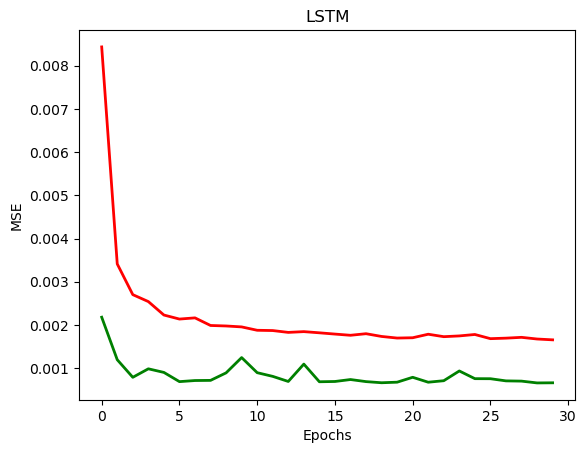

In [76]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
# plt.plot(history.history['val_accuracy'], 'b',linewidth=2, label='Validation Accuracy')
# # plt.plot(history.history['accuracy'], 'y',linewidth=2, label='Train Accuracy')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [96]:
model.save('BTC1_win10_2000.h5')

In [77]:
def cnn_model(input_data, output_size, activ_func='linear',dropout=0.2, loss='mse', optimizer='adam'):
    
    model = Sequential()
    
    
    model.add(Conv1D(filters=512, kernel_size=3, activation='relu', input_shape=(10, 6)))

    
    model.add(MaxPooling1D(pool_size=2))

    
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))

   
    model.add(MaxPooling1D(pool_size=2))
    
    
    model.add(Flatten())

   
    model.add(Dropout(0.2))

    
    model.add(Dense(128, activation='relu'))

   
    model.add(Dropout(0.3))

    
    model.add(Dense(1, activation='linear'))


    model.compile(loss=loss, optimizer=optimizer)
    
    return model
    


In [78]:
model1 = cnn_model(X_train, output_size=1,activ_func='linear', dropout=0.2, loss='mse',optimizer='adam')
history1 = model1.fit(X_train, 
            y_train, 
            validation_data=(X_test, y_test), 
            epochs=100, 
            batch_size=32, 
            verbose=1, 
            shuffle=True,
            )

Epoch 1/100
50/50 [==============================] - 1s 6ms/step - loss: 0.0211 - val_loss: 0.0031
Epoch 2/100
50/50 [==============================] - 0s 5ms/step - loss: 0.0070 - val_loss: 0.0022
Epoch 3/100
50/50 [==============================] - 0s 4ms/step - loss: 0.0050 - val_loss: 0.0015
Epoch 4/100
50/50 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0018
Epoch 5/100
50/50 [==============================] - 0s 4ms/step - loss: 0.0037 - val_loss: 0.0019
Epoch 6/100
50/50 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 0.0013
Epoch 7/100
50/50 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0012
Epoch 8/100
50/50 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0012
Epoch 9/100
50/50 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0014
Epoch 10/100
50/50 [==============================] - 0s 5ms/step - loss: 0.0031 - val_loss: 0.0014
Epoch 11/

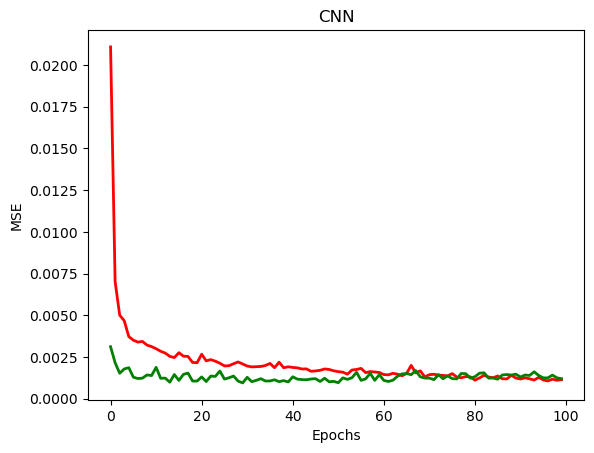

In [79]:
import matplotlib.pyplot as plt
plt.plot(history1.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history1.history['val_loss'], 'g',linewidth=2, label='Validation loss')
# plt.plot(history.history['val_accuracy'], 'b',linewidth=2, label='Validation Accuracy')
# # plt.plot(history.history['accuracy'], 'y',linewidth=2, label='Train Accuracy')
plt.title('CNN')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [80]:
targets = hist[target_col][:-10]
preds = model.predict(X_test).squeeze()

13/13 [==============================] - 0s 9ms/step


In [81]:
mae=mean_absolute_error(preds, y_test)
print("Mean Absolute Error = "+str(mae))

Mean Absolute Error = 0.018471408743172418


In [82]:
MSE=mean_squared_error(preds, y_test)
print("Mean Squared Error = "+str(MSE))

Mean Squared Error = 0.0006608660252887407


In [83]:
R2=r2_score(y_test, preds)
print(R2)

0.8926889207644038


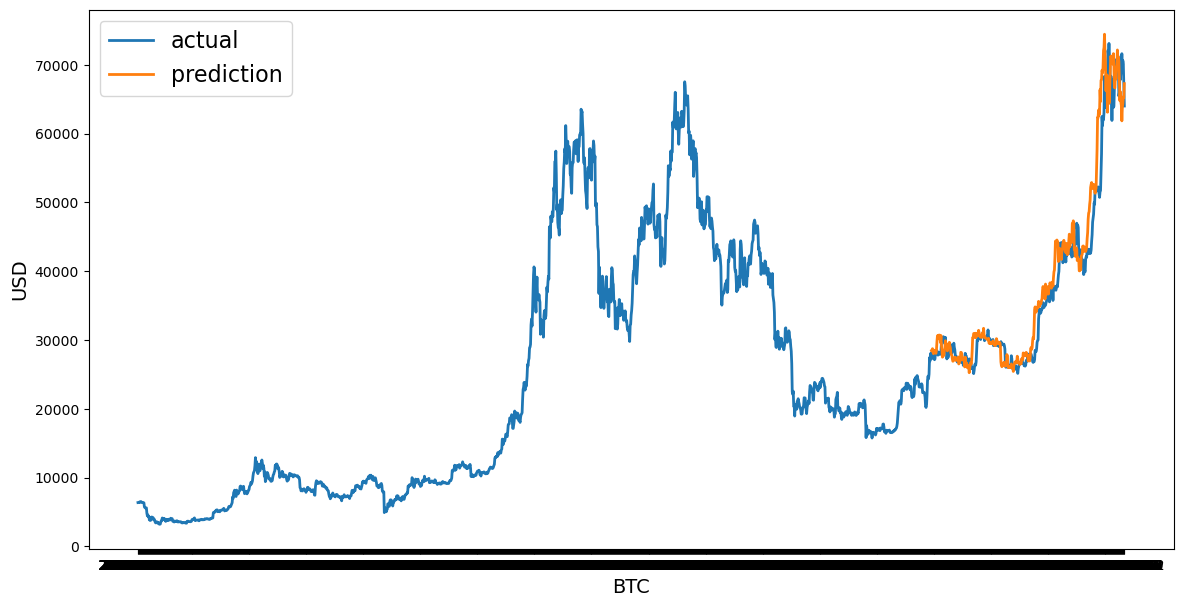

In [84]:
preds = test[target_col].values[:-10] * (preds+1)
preds = pd.Series(index=test[target_col].index[:-10], data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=2)

In [5]:
model = load_model('BTC1_win10_2000.h5')
model1 = load_model('BTC_win10_1250.h5')
model2 = load_model('BTC2_win10_1250.h5')

2023-12-18 17:11:49.292740: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [90]:
fore_data = hist
# future_timestamps = pd.date_range(start=pd.date_range(start=fore_data.index[-1], periods=2, freq='D')[1], periods=20, freq='D')
# future_df = pd.DataFrame(columns=fore_data.columns,index=future_timestamps)
# fore_data = pd.concat([fore_data, future_df])

for i in range(5):
    input_value = (np.array(fore_data[-10:]).reshape(1,10,6))
    
    fore_data_scaled = input_value/input_value[0][0] - 1 #scaling
    
    fore_pred = model.predict(fore_data_scaled)
    
    fore_pred = (fore_pred + 1) * input_value[0][0]#reverse scaling
    
    # generating new timestamps
    first_valid_index = fore_data.apply(lambda row: row.first_valid_index(), axis=1)
    last_valid_index = pd.Timestamp(first_valid_index.index[-1])
    # print(last_valid_index,' pdjknfk')
    new_index = pd.DatetimeIndex([(last_valid_index + pd.Timedelta(days=1))])
    new_row_df = pd.DataFrame(data=fore_pred, index=new_index, columns=fore_data.columns)
    
    fore_data = pd.concat([fore_data, new_row_df], axis=0)



1/1 [==============================] - 0s 16ms/step


In [91]:
fore_data.tail(7)

,high,low,open,volumefrom,volumeto,close
2024-04-22,67257.680000,64536.420000,64955.820000,22839.750000,1.510231e+09,66854.240000
2024-04-23,67211.150000,65835.930000,66854.240000,17347.440000,1.154157e+09,66253.150000
2024-04-24,67375.207506,63647.109309,65479.472826,41901.103974,2.687852e+09,67263.479521
2024-04-25,70744.946491,65907.357390,69542.335250,43331.426972,2.811081e+09,67090.829209
2024-04-26,69097.024221,66180.406920,68090.179863,38143.463419,2.398016e+09,68495.229231
2024-04-27,72354.474022,66946.736270,71592.754936,46555.632905,2.874734e+09,68742.536658
2024-04-28,70364.812135,66689.884598,67188.140649,34483.173477,2.162854e+09,69630.205963


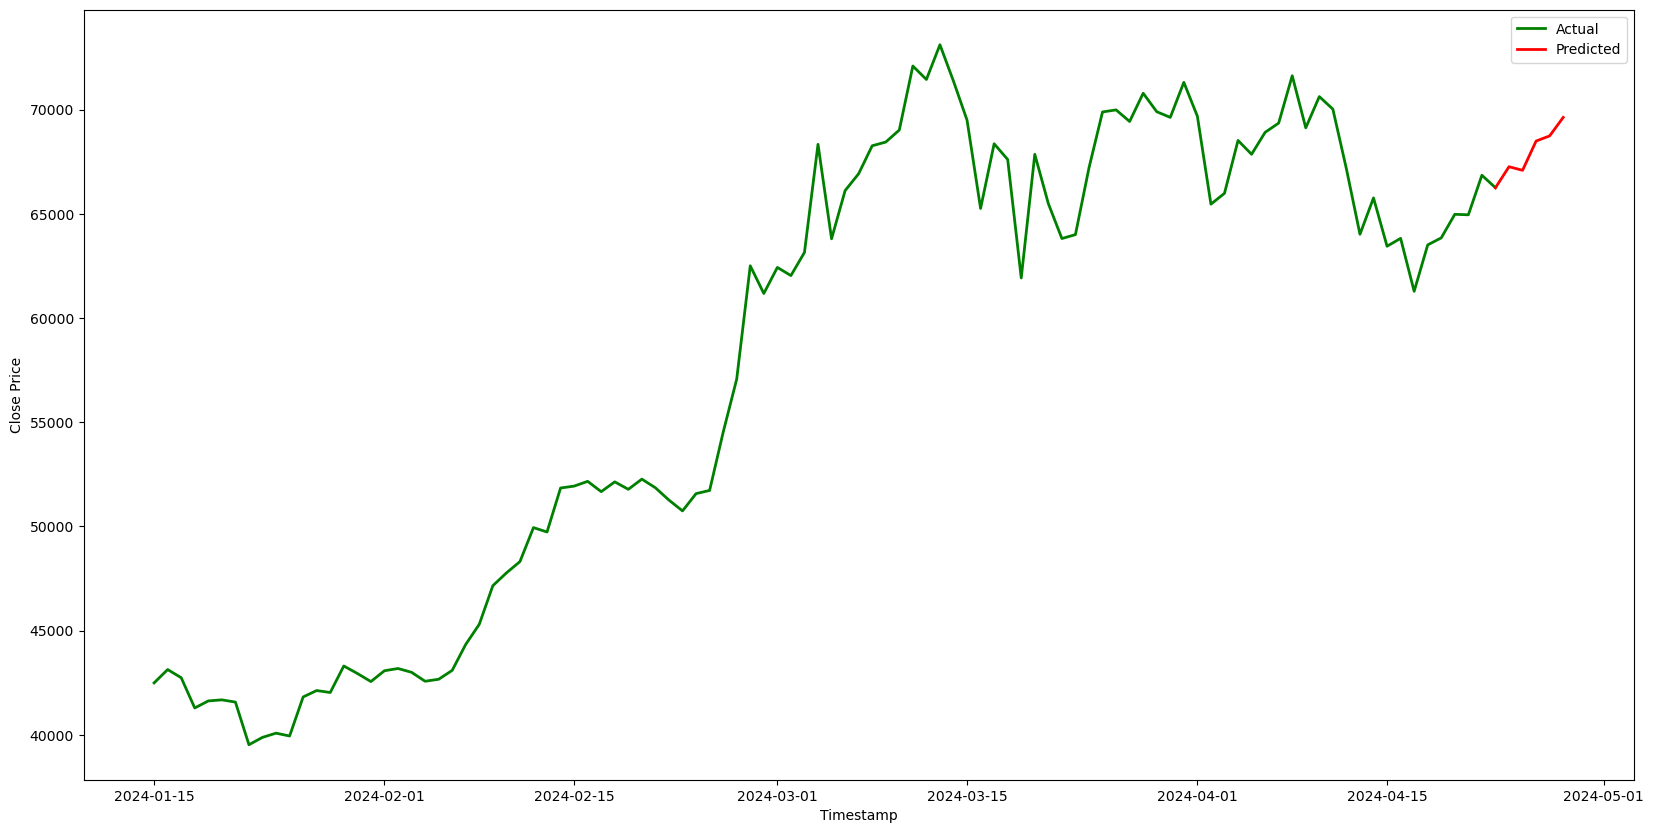

In [92]:
plt.figure(figsize=(20,10))

plt.plot(hist['close'][-100:],'g',linewidth=2,label = 'Actual')
plt.plot(fore_data['close'][-6:],'r',linewidth=2,label = 'Predicted')
plt.legend()
plt.xlabel('Timestamp')
plt.ylabel('Close Price')
plt.show()


In [93]:
fore_data[-6:]

,high,low,open,volumefrom,volumeto,close
2024-04-23,67211.150000,65835.930000,66854.240000,17347.440000,1.154157e+09,66253.150000
2024-04-24,67375.207506,63647.109309,65479.472826,41901.103974,2.687852e+09,67263.479521
2024-04-25,70744.946491,65907.357390,69542.335250,43331.426972,2.811081e+09,67090.829209
2024-04-26,69097.024221,66180.406920,68090.179863,38143.463419,2.398016e+09,68495.229231
2024-04-27,72354.474022,66946.736270,71592.754936,46555.632905,2.874734e+09,68742.536658
2024-04-28,70364.812135,66689.884598,67188.140649,34483.173477,2.162854e+09,69630.205963


In [94]:
merged_data = pd.concat([hist['close'][-100:],fore_data['close'][-6:]],axis=1,keys=['close1','close2'])

In [95]:
merged_data

,close1,close2
2024-01-15,42491.26,NaN
2024-01-16,43130.88,NaN
2024-01-17,42739.27,NaN
2024-01-18,41286.68,NaN
2024-01-19,41625.47,NaN
...,...,...
2024-04-24,NaN,67263.479521
2024-04-25,NaN,67090.829209
2024-04-26,NaN,68495.229231
2024-04-27,NaN,68742.536658


2024-04-22
